<a href="https://colab.research.google.com/github/ADS77/Brain-Cancer-Classification/blob/main/Thesis_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


In [ ]:
!mkdir TRAIN TRAIN/GLIOMA TRAIN/MENINGIOMA TRAIN/PITUITARY TRAIN/NO
!mkdir VAL VAL/GLIOMA VAL/MENINGIOMA VAL/PITUITARY VAL/NO
!mkdir TEST TEST/GLIOMA TEST/MENINGIOMA TEST/PITUITARY TEST/NO

In [ ]:
IMG_PATH = '/content/drive/MyDrive/Thesis/Brain_Cancer_Dataset_new2/'
import os
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
  if not CLASS.startswith('.'):
    IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
    for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
      img = IMG_PATH + CLASS + '/' + FILE_NAME
      t=n%10
      if (t==0):
        shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
      elif (t==4 or t==7):
        shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)
      else:
        shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)

In [ ]:
def load_data(dir_path, img_size):
    
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [ ]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)
#print(X_train.shape)
#print(y_train.shape)

100%|██████████| 4/4 [00:00<00:00, 13220.82it/s]


0 images loaded from TRAIN/ directory.


100%|██████████| 4/4 [00:00<00:00, 11252.32it/s]


0 images loaded from TEST/ directory.


100%|██████████| 4/4 [00:00<00:00, 16496.77it/s]

0 images loaded from VAL/ directory.


In [ ]:
def crop_imgs(set_name, add_pixels_value=0):
  
    #Finds the extreme points on the image and crops the rectangular out of them
    
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [ ]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

In [ ]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'GLIOMA/'+str(i)+'.jpg', img)
        elif imclass == 1:
            cv2.imwrite(folder_name+'MENINGIOMA/'+str(i)+'.jpg', img)
        elif imclass == 2:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        elif imclass == 3:
            cv2.imwrite(folder_name+'PITUITARY/'+str(i)+'.jpg', img)
        i += 1

In [ ]:
!mkdir TRAIN_CROP TRAIN_CROP/GLIOMA TRAIN_CROP/MENINGIOMA TRAIN_CROP/PITUITARY TRAIN_CROP/NO
!mkdir VAL_CROP VAL_CROP/GLIOMA VAL_CROP/MENINGIOMA VAL_CROP/PITUITARY VAL_CROP/NO
!mkdir TEST_CROP TEST_CROP/GLIOMA TEST_CROP/MENINGIOMA TEST_CROP/PITUITARY TEST_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [ ]:
def preprocess_imgs(set_name, img_size):
    
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [ ]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [ ]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'
TEST_DIR = 'TEST_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='categorical',
    seed=RANDOM_SEED
)


test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='categorical',
    seed=RANDOM_SEED
)

Found 0 images belonging to 4 classes.
Found 0 images belonging to 4 classes.
Found 0 images belonging to 4 classes.


In [ ]:
# load base model
vgg16_weight_path = '/content/drive/MyDrive/Thesis/Keras_pretrained_models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

In [ ]:
NUM_CLASSES = 4

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

model.layers[0].trainable = False

model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    #optimizer='adam',
    #optimizer='SGD',
    metrics=['accuracy']
)

model.summary()

In [ ]:
EPOCHS = 100
es = EarlyStopping(
    monitor='loss', 
    mode='min',
    patience=10
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=int(2651/32),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=int(756/16),
    callbacks=[es]
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/100
82/82 [==============================] - 105s 677ms/step - loss: 17.1560 - accuracy: 0.5308 - val_loss: 4.1889 - val_accuracy: 0.8910
Epoch 2/100
82/82 [==============================] - 44s 539ms/step - loss: 7.3540 - accuracy: 0.7612 - val_loss: 1.8096 - val_accuracy: 0.9215
Epoch 3/100
82/82 [==============================] - 45s 544ms/step - loss: 6.0060 - accuracy: 0.8235 - val_loss: 1.7295 - val_accuracy: 0.9415
Epoch 4/100
82/82 [==============================] - 44s 540ms/step - loss: 4.1864 - accuracy: 0.8713 - val_loss: 2.3581 - val_accuracy: 0.9215
Epoch 5/100
82/82 [==============================] - 44s 539ms/step - loss: 4.2023 - accuracy: 0.8578 - val_loss: 1.1823 - val_accuracy: 0.9548
Epoch 6/100
82/82 [==============================] - 44s 537ms/step - loss: 4.4858 - accuracy: 0.8713 - val_loss: 1.3088 - val_accuracy: 0.9481
Epoch 7/100
82/82 [==============================] - 44s 538ms/step - loss: 3.7675 - accuracy: 0.8854 - val_loss: 1.4789 - val_accurac

Accuracy of Train Set: 0.9499809145927429
Accuracy of Validation Set: 0.9734042286872864


Loss of Train Set: 1.6063973903656006
Loss of Validation Set: 0.785325825214386


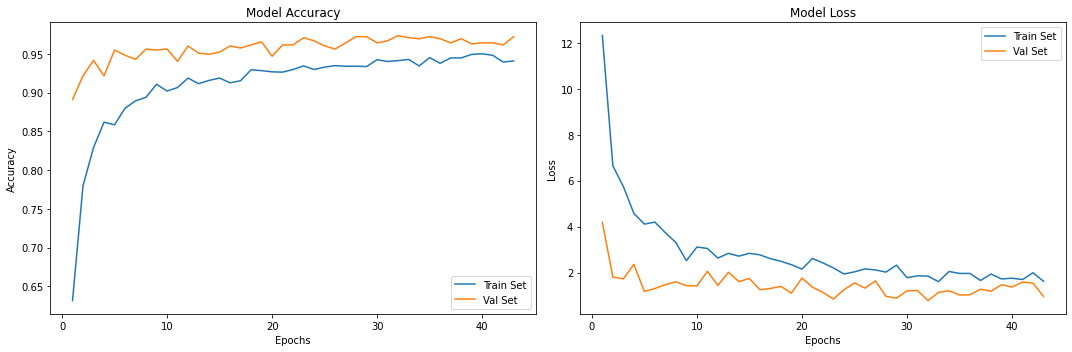

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print("Accuracy of Train Set: " + str(max(acc)))
print("Accuracy of Validation Set: " + str(max(val_acc)))

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

print("\n\nLoss of Train Set: " + str(min(loss)))
print("Loss of Validation Set: " + str(min(val_loss)))

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Thesis/Brain_Cancer_Final/Accuracy_Loss_graph.png')
plt.show()

In [ ]:
test_score = model.evaluate(test_generator)
print('Test loss {:.4f}, accuracy {:.2f}%'.format(test_score[0], test_score[1] * 100))

24/24 [==============================] - 5s 213ms/step - loss: 1.1372 - accuracy: 0.9605
Test loss 1.1372, accuracy 96.05%


In [ ]:
model.save('/content/drive/MyDrive/Thesis/Brain_Cancer_Final/brain_cancer_vgg16.h5')

In [ ]:
#Defining function for confusion matrix plot
def Plot_Confusion_Matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    title=''
    #Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#print(cm)

    fig, ax = plt.subplots(figsize=(8,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    #Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

In [ ]:
y_pred=model.predict_classes(X_test_prep)
y_true=np.argmax(y_test)

In [ ]:
print(y_pred)

Confusion matrix, without normalization
Normalized confusion matrix


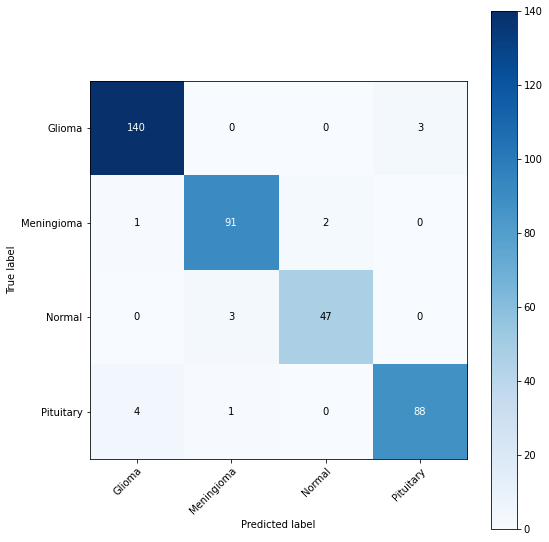

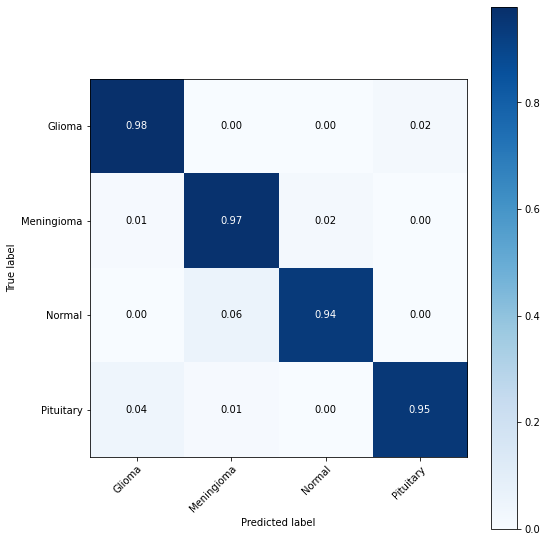

In [ ]:
#Defining the class labels
class_names=['Glioma', 'Meningioma', 'Normal', 'Pituitary']

Plot_Confusion_Matrix(y_test, y_pred, classes = class_names)
Plot_Confusion_Matrix(y_test, y_pred, classes = class_names, normalize = True)


In [ ]:
y_pred_val=model.predict_classes(X_val_prep)
y_true_val=np.argmax(y_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



Confusion matrix, without normalization
Normalized confusion matrix


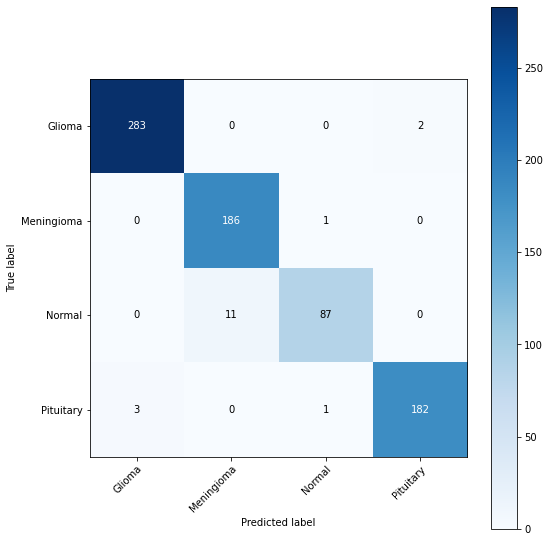

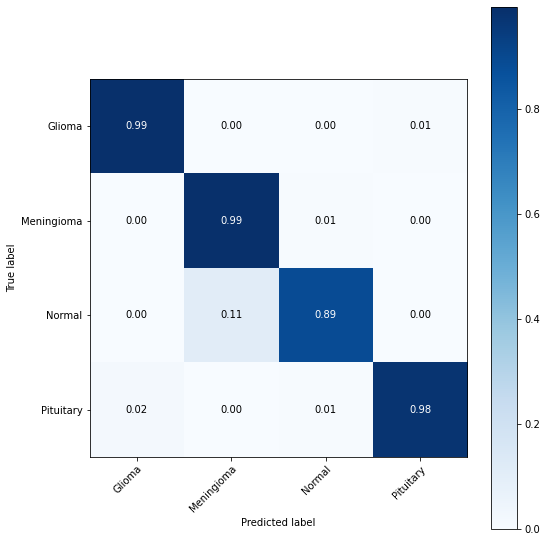

In [ ]:
#Defining the class labels
class_names=['Glioma', 'Meningioma', 'Normal', 'Pituitary']

# Plotting non-normalized confusion matrix
Plot_Confusion_Matrix(y_val, y_pred_val, classes = class_names)
Plot_Confusion_Matrix(y_val, y_pred_val, classes = class_names, normalize = True)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.6f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.6f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.6f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.6f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.6f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.6f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.6f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.6f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.6f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.6f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report:\n')
print(classification_report(y_test, y_pred, target_names=['Glioma', 'Meningioma', 'Normal', 'Pituitary']))


Accuracy: 0.963158

Micro Precision: 0.963158
Micro Recall: 0.963158
Micro F1-score: 0.963158

Macro Precision: 0.962407
Macro Recall: 0.958336
Macro F1-score: 0.960300

Weighted Precision: 0.963169
Weighted Recall: 0.963158
Weighted F1-score: 0.963099

Classification Report:

              precision    recall  f1-score   support

      Glioma       0.97      0.98      0.97       143
  Meningioma       0.96      0.97      0.96        94
      Normal       0.96      0.94      0.95        50
   Pituitary       0.97      0.95      0.96        93

    accuracy                           0.96       380
   macro avg       0.96      0.96      0.96       380
weighted avg       0.96      0.96      0.96       380



In [ ]:
layer_name = 'dense' #This is first FCL
FC_layer_model = Model(model.inputs,model.get_layer(layer_name).output)
import glob
import os
import cv2
total_train_image=2651
i=0
features=np.zeros(shape=(total_train_image,128))
for directory_path in glob.glob("/content/TRAIN_CROP/*"):
    for img_path in glob.glob(os.path.join(directory_path, "*.*")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = np.expand_dims(img, axis=0)
        FC_output = FC_layer_model.predict(img)
        #print(FC_output)
        features[i]=FC_output
        #print(i)
        #print(features[i])
        i+=1

np.save('/content/drive/MyDrive/Thesis/Brain_Cancer_Final/vgg16_features', features)

In [ ]:
layer_name = 'dense'
FC_layer_model = Model(model.inputs,model.get_layer(layer_name).output)
import glob
import os
import cv2
import numpy as np
import pandas as pd
features = np.load('/content/drive/MyDrive/Thesis/Brain_Cancer_Final/vgg16_features.npy')
#print(features)
feature_col=[]
for i in range(128):
    feature_col.append("f_"+str(i))
    i+=1
train_features=pd.DataFrame(data=features,columns=feature_col)
#print(train_features)
feature_col = np.array(feature_col)

import glob
import os
train_brain_cancer_labels = []
for directory_path in glob.glob("/content/TRAIN_CROP/*"):
    brain_cancer_label = directory_path.split("\\")[-1]
    
    for img_path in glob.glob(os.path.join(directory_path, "*.*")):
        train_brain_cancer_labels.append(brain_cancer_label)

train_brain_cancer_labels = np.array(train_brain_cancer_labels)
print('Training Shape:', train_brain_cancer_labels.shape)
label_to_id = {v:i for i,v in enumerate(np.unique(train_brain_cancer_labels))}
id_to_label = {v: k for k, v in label_to_id.items()}
train_label_ids = np.array([label_to_id[x] for x in train_brain_cancer_labels])
#print(train_label_ids)
train_class = list(np.unique(train_label_ids))
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_label_ids.shape)
#train_class

import cv2
i=0
features_test=np.zeros(shape=(380,128))
for directory_path in glob.glob("/content/TEST_CROP/*"):
    for img_path in glob.glob(os.path.join(directory_path, "*.*")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)    
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = np.expand_dims(img, axis=0)
        FC_output = FC_layer_model.predict(img)
        features_test[i]= FC_output
        i+=1

test_features=pd.DataFrame(data=features_test,columns=feature_col)
feature_col = np.array(feature_col)
test_brain_cancer_labels = [] 
for directory_path in glob.glob("/content/TEST_CROP/*"):
    brain_cancer_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.*")):
        
        test_brain_cancer_labels.append(brain_cancer_label)

test_brain_cancer_labels = np.array(test_brain_cancer_labels)
label_to_id = {v:i for i,v in enumerate(np.unique(test_brain_cancer_labels))}
id_to_label = {v: k for k, v in label_to_id.items()}
test_label_ids = np.array([label_to_id[x] for x in test_brain_cancer_labels])

print('Test Features Shape:', test_features.shape)
print('Test Labels Shape:', test_label_ids.shape)
np.save('/content/drive/MyDrive/Thesis/Brain_Cancer_Final/Test_features', test_features)
np.save('/content/drive/MyDrive/Thesis/Brain_Cancer_Final/Train_features', train_features)
np.save('/content/drive/MyDrive/Thesis/Brain_Cancer_Final/Train_label_ids', train_label_ids)
np.save('/content/drive/MyDrive/Thesis/Brain_Cancer_Final/Test_label_ids', test_label_ids)

Training Shape: (2651,)
Training Features Shape: (2651, 128)
Training Labels Shape: (2651,)
Test Features Shape: (380, 128)
Test Labels Shape: (380,)


In [ ]:
from sklearn import preprocessing
train_features = preprocessing.normalize(train_features)
test_features = preprocessing.normalize(test_features)

Confusion matrix, without normalization

Accuracy: 0.976316

Micro Precision: 0.976316
Micro Recall: 0.976316
Micro F1-score: 0.976316

Macro Precision: 0.980508
Macro Recall: 0.979595
Macro F1-score: 0.980041

Weighted Precision: 0.976321
Weighted Recall: 0.976316
Weighted F1-score: 0.976307

Classification Report:

              precision    recall  f1-score   support

      Glioma       0.97      0.97      0.97       143
  Meningioma       0.99      0.99      0.99        94
      Normal       1.00      1.00      1.00        50
   Pituitary       0.97      0.96      0.96        93

    accuracy                           0.98       380
   macro avg       0.98      0.98      0.98       380
weighted avg       0.98      0.98      0.98       380



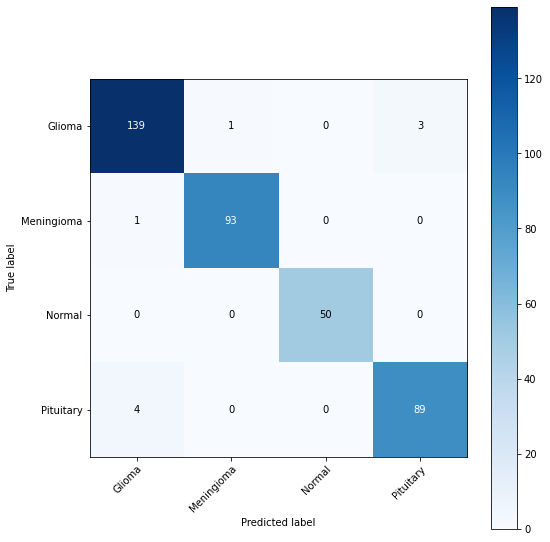

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
#create a new random forest classifier
import pickle
rf = RandomForestClassifier()
#create a dictionary of all values we want to test for n_estimators
params_rf = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [4, 5],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [50, 100, 200, 300, 1000]
}

rf.fit(train_features, train_label_ids)
filename = '/content/drive/MyDrive/Thesis/Brain_Cancer_Final/rf_model.sav'
pickle.dump(rf, open(filename, 'wb'))


loaded_model = pickle.load(open(filename, 'rb'))
y_test = loaded_model.predict(test_features)

class_names=['Glioma', 'Meningioma', 'Normal', 'Pituitary']
Plot_Confusion_Matrix(test_label_ids, y_test, classes = class_names)


print('\nAccuracy: {:.6f}\n'.format(accuracy_score(test_label_ids, y_test)))

print('Micro Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='micro')))
print('Micro Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='micro')))
print('Micro F1-score: {:.6f}\n'.format(f1_score(test_label_ids, y_test, average='micro')))

print('Macro Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='macro')))
print('Macro Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='macro')))
print('Macro F1-score: {:.6f}\n'.format(f1_score(test_label_ids, y_test, average='macro')))

print('Weighted Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='weighted')))
print('Weighted Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='weighted')))
print('Weighted F1-score: {:.6f}'.format(f1_score(test_label_ids, y_test, average='weighted')))

print('\nClassification Report:\n')
print(classification_report(test_label_ids, y_test, target_names=['Glioma', 'Meningioma', 'Normal', 'Pituitary']))


Confusion matrix, without normalization

Accuracy: 0.981579

Micro Precision: 0.981579
Micro Recall: 0.981579
Micro F1-score: 0.981579

Macro Precision: 0.984116
Macro Recall: 0.981719
Macro F1-score: 0.982885

Weighted Precision: 0.981634
Weighted Recall: 0.981579
Weighted F1-score: 0.981587

Classification Report:

              precision    recall  f1-score   support

      Glioma       0.98      0.98      0.98       143
  Meningioma       0.98      0.99      0.98        94
      Normal       1.00      0.98      0.99        50
   Pituitary       0.98      0.98      0.98        93

    accuracy                           0.98       380
   macro avg       0.98      0.98      0.98       380
weighted avg       0.98      0.98      0.98       380



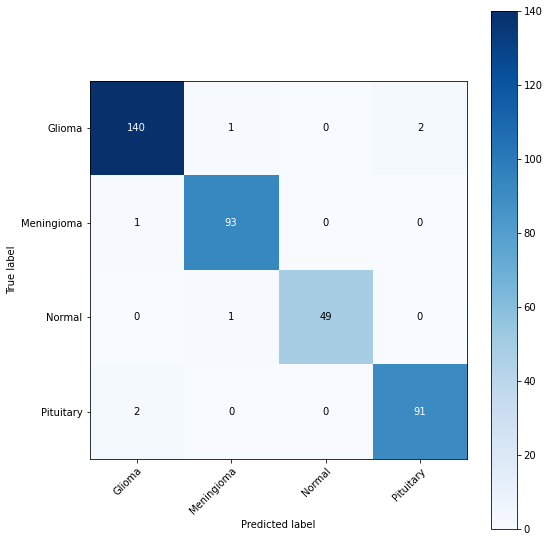

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.svm import SVC
param_grid = {'kernel':['rbf']}
svc_gs = SVC(probability=True, kernel='rbf')

svc_gs.fit(train_features, train_label_ids)
filename = '/content/drive/MyDrive/Thesis/Brain_Cancer_Final/svc_model.sav'
pickle.dump(svc_gs, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))
y_test = loaded_model.predict(test_features)


class_names=['Glioma', 'Meningioma', 'Normal', 'Pituitary']
Plot_Confusion_Matrix(test_label_ids, y_test, classes = class_names)


print('\nAccuracy: {:.6f}\n'.format(accuracy_score(test_label_ids, y_test)))

print('Micro Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='micro')))
print('Micro Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='micro')))
print('Micro F1-score: {:.6f}\n'.format(f1_score(test_label_ids, y_test, average='micro')))

print('Macro Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='macro')))
print('Macro Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='macro')))
print('Macro F1-score: {:.6f}\n'.format(f1_score(test_label_ids, y_test, average='macro')))

print('Weighted Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='weighted')))
print('Weighted Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='weighted')))
print('Weighted F1-score: {:.6f}'.format(f1_score(test_label_ids, y_test, average='weighted')))

print('\nClassification Report:\n')
print(classification_report(test_label_ids, y_test, target_names=['Glioma', 'Meningioma', 'Normal', 'Pituitary']))

Confusion matrix, without normalization

Accuracy: 0.981579

Micro Precision: 0.981579
Micro Recall: 0.981579
Micro F1-score: 0.981579

Macro Precision: 0.983372
Macro Recall: 0.976156
Macro F1-score: 0.979498

Weighted Precision: 0.981799
Weighted Recall: 0.981579
Weighted F1-score: 0.981533

Classification Report:

              precision    recall  f1-score   support

      Glioma       0.99      0.99      0.99       143
  Meningioma       0.97      0.99      0.98        94
      Normal       1.00      0.94      0.97        50
   Pituitary       0.98      0.99      0.98        93

    accuracy                           0.98       380
   macro avg       0.98      0.98      0.98       380
weighted avg       0.98      0.98      0.98       380



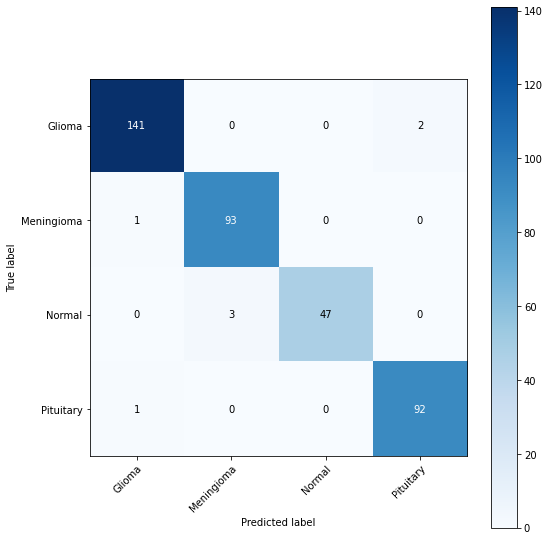

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
classifier = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=4),
    n_estimators=200
)
classifier.fit(train_features, train_label_ids)
filename = '/content/drive/MyDrive/Thesis/Brain_Cancer_Final/AB_model.sav'
pickle.dump(classifier, open(filename, 'wb'))
 
loaded_model = pickle.load(open(filename, 'rb'))
y_test = loaded_model.predict(test_features)

Plot_Confusion_Matrix(test_label_ids, y_test, classes = class_names)


print('\nAccuracy: {:.6f}\n'.format(accuracy_score(test_label_ids, y_test)))

print('Micro Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='micro')))
print('Micro Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='micro')))
print('Micro F1-score: {:.6f}\n'.format(f1_score(test_label_ids, y_test, average='micro')))

print('Macro Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='macro')))
print('Macro Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='macro')))
print('Macro F1-score: {:.6f}\n'.format(f1_score(test_label_ids, y_test, average='macro')))

print('Weighted Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='weighted')))
print('Weighted Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='weighted')))
print('Weighted F1-score: {:.6f}'.format(f1_score(test_label_ids, y_test, average='weighted')))

print('\nClassification Report:\n')
print(classification_report(test_label_ids, y_test, target_names=['Glioma', 'Meningioma', 'Normal', 'Pituitary']))

Confusion matrix, without normalization

Accuracy: 0.981579

Micro Precision: 0.981579
Micro Recall: 0.981579
Micro F1-score: 0.981579

Macro Precision: 0.983347
Macro Recall: 0.979407
Macro F1-score: 0.981238

Weighted Precision: 0.981762
Weighted Recall: 0.981579
Weighted F1-score: 0.981579

Classification Report:

              precision    recall  f1-score   support

      Glioma       0.99      0.98      0.98       143
  Meningioma       0.97      0.99      0.98        94
      Normal       1.00      0.96      0.98        50
   Pituitary       0.98      0.99      0.98        93

    accuracy                           0.98       380
   macro avg       0.98      0.98      0.98       380
weighted avg       0.98      0.98      0.98       380



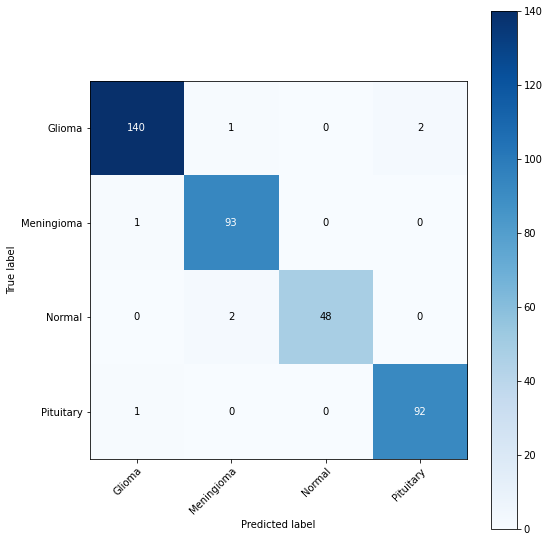

In [ ]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators=[('rf', rf), ('svm', svc_gs),('classifier', classifier)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')

ensemble.fit(train_features, train_label_ids)
filename = '/content/drive/MyDrive/Thesis/Brain_Cancer_Final/en_hard_model.sav'
pickle.dump(ensemble, open(filename, 'wb'))
 
loaded_model = pickle.load(open(filename, 'rb'))
y_test = loaded_model.predict(test_features)

Plot_Confusion_Matrix(test_label_ids, y_test, classes = class_names)

print('\nAccuracy: {:.6f}\n'.format(accuracy_score(test_label_ids, y_test)))

print('Micro Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='micro')))
print('Micro Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='micro')))
print('Micro F1-score: {:.6f}\n'.format(f1_score(test_label_ids, y_test, average='micro')))

print('Macro Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='macro')))
print('Macro Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='macro')))
print('Macro F1-score: {:.6f}\n'.format(f1_score(test_label_ids, y_test, average='macro')))

print('Weighted Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='weighted')))
print('Weighted Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='weighted')))
print('Weighted F1-score: {:.6f}'.format(f1_score(test_label_ids, y_test, average='weighted')))

print('\nClassification Report:\n')
print(classification_report(test_label_ids, y_test, target_names=['Glioma', 'Meningioma', 'Normal', 'Pituitary']))

Confusion matrix, without normalization

Accuracy: 0.978947

Micro Precision: 0.978947
Micro Recall: 0.978947
Micro F1-score: 0.978947

Macro Precision: 0.980747
Macro Recall: 0.977659
Macro F1-score: 0.979034

Weighted Precision: 0.979203
Weighted Recall: 0.978947
Weighted F1-score: 0.978949

Classification Report:

              precision    recall  f1-score   support

      Glioma       0.99      0.97      0.98       143
  Meningioma       0.97      0.99      0.98        94
      Normal       1.00      0.96      0.98        50
   Pituitary       0.97      0.99      0.98        93

    accuracy                           0.98       380
   macro avg       0.98      0.98      0.98       380
weighted avg       0.98      0.98      0.98       380



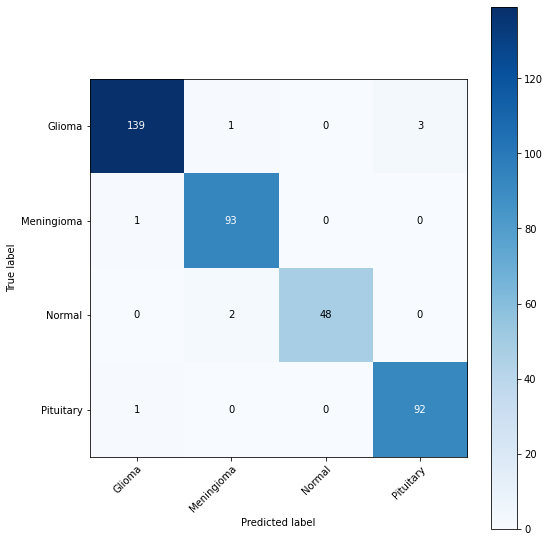

In [ ]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators_soft=[('rf', rf), ('svm', svc_gs),('classifier', classifier)]
#create our voting classifier, inputting our models
ensemble_soft = VotingClassifier(estimators_soft, voting='soft')

ensemble_soft.fit(train_features, train_label_ids)
filename = '/content/drive/MyDrive/Thesis/Brain_Cancer_Final/en_soft_model.sav'
pickle.dump(ensemble_soft, open(filename, 'wb'))
 
loaded_model = pickle.load(open(filename, 'rb'))
y_test = loaded_model.predict(test_features)

Plot_Confusion_Matrix(test_label_ids, y_test, classes = class_names)

print('\nAccuracy: {:.6f}\n'.format(accuracy_score(test_label_ids, y_test)))

print('Micro Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='micro')))
print('Micro Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='micro')))
print('Micro F1-score: {:.6f}\n'.format(f1_score(test_label_ids, y_test, average='micro')))

print('Macro Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='macro')))
print('Macro Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='macro')))
print('Macro F1-score: {:.6f}\n'.format(f1_score(test_label_ids, y_test, average='macro')))

print('Weighted Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='weighted')))
print('Weighted Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='weighted')))
print('Weighted F1-score: {:.6f}'.format(f1_score(test_label_ids, y_test, average='weighted')))

print('\nClassification Report:\n')
print(classification_report(test_label_ids, y_test, target_names=['Glioma', 'Meningioma', 'Normal', 'Pituitary']))

Confusion matrix, without normalization

Accuracy: 0.971053

Micro Precision: 0.971053
Micro Recall: 0.971053
Micro F1-score: 0.971053

Macro Precision: 0.973819
Macro Recall: 0.967743
Macro F1-score: 0.970646

Weighted Precision: 0.971253
Weighted Recall: 0.971053
Weighted F1-score: 0.971007

Classification Report:

              precision    recall  f1-score   support

      Glioma       0.96      0.99      0.97       143
  Meningioma       0.98      0.98      0.98        94
      Normal       0.98      0.96      0.97        50
   Pituitary       0.98      0.95      0.96        93

    accuracy                           0.97       380
   macro avg       0.97      0.97      0.97       380
weighted avg       0.97      0.97      0.97       380



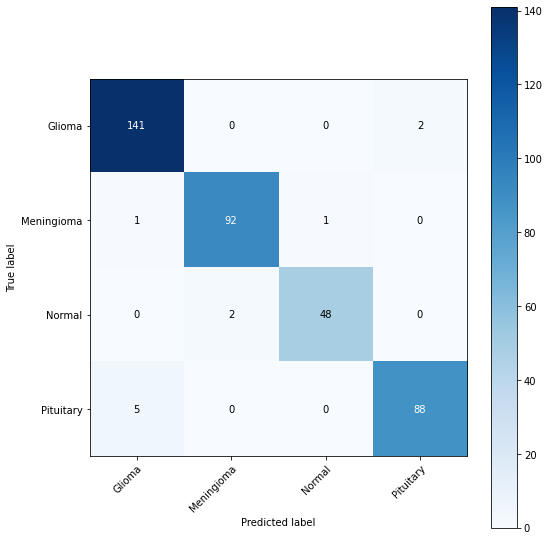

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_3 = KNeighborsClassifier(n_neighbors=3)

knn_3.fit(train_features, train_label_ids)

filename = '/content/drive/MyDrive/Thesis/Brain_Cancer_Final/knn_3_model.sav'
pickle.dump(knn_3, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))
y_test = loaded_model.predict(test_features) 

Plot_Confusion_Matrix(test_label_ids, y_test, classes = class_names)


print('\nAccuracy: {:.6f}\n'.format(accuracy_score(test_label_ids, y_test)))

print('Micro Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='micro')))
print('Micro Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='micro')))
print('Micro F1-score: {:.6f}\n'.format(f1_score(test_label_ids, y_test, average='micro')))

print('Macro Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='macro')))
print('Macro Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='macro')))
print('Macro F1-score: {:.6f}\n'.format(f1_score(test_label_ids, y_test, average='macro')))

print('Weighted Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='weighted')))
print('Weighted Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='weighted')))
print('Weighted F1-score: {:.6f}'.format(f1_score(test_label_ids, y_test, average='weighted')))

print('\nClassification Report:\n')
print(classification_report(test_label_ids, y_test, target_names=['Glioma', 'Meningioma', 'Normal', 'Pituitary']))

Confusion matrix, without normalization

Accuracy: 0.971053

Micro Precision: 0.971053
Micro Recall: 0.971053
Micro F1-score: 0.971053

Macro Precision: 0.976276
Macro Recall: 0.970995
Macro F1-score: 0.973513

Weighted Precision: 0.971285
Weighted Recall: 0.971053
Weighted F1-score: 0.971046

Classification Report:

              precision    recall  f1-score   support

      Glioma       0.96      0.98      0.97       143
  Meningioma       0.97      0.98      0.97        94
      Normal       1.00      0.98      0.99        50
   Pituitary       0.98      0.95      0.96        93

    accuracy                           0.97       380
   macro avg       0.98      0.97      0.97       380
weighted avg       0.97      0.97      0.97       380



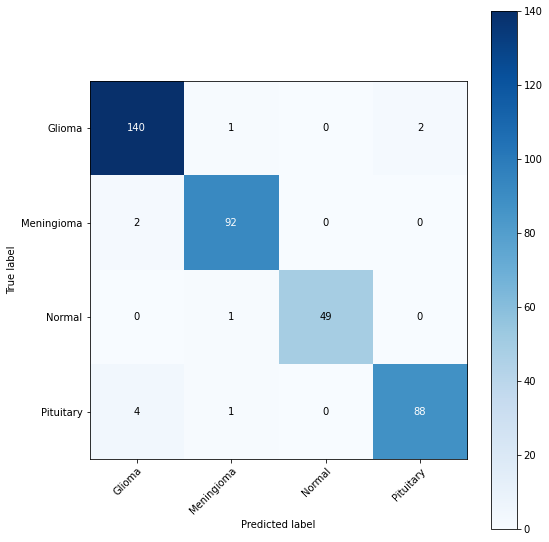

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='liblinear', random_state=0)

lr.fit(train_features, train_label_ids)

filename = '/content/drive/MyDrive/Thesis/Brain_Cancer_Final/lgr_model.sav'
pickle.dump(lr, open(filename, 'wb'))


loaded_model = pickle.load(open(filename, 'rb'))
y_test = loaded_model.predict(test_features)

Plot_Confusion_Matrix(test_label_ids, y_test, classes = class_names)

print('\nAccuracy: {:.6f}\n'.format(accuracy_score(test_label_ids, y_test)))

print('Micro Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='micro')))
print('Micro Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='micro')))
print('Micro F1-score: {:.6f}\n'.format(f1_score(test_label_ids, y_test, average='micro')))

print('Macro Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='macro')))
print('Macro Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='macro')))
print('Macro F1-score: {:.6f}\n'.format(f1_score(test_label_ids, y_test, average='macro')))

print('Weighted Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='weighted')))
print('Weighted Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='weighted')))
print('Weighted F1-score: {:.6f}'.format(f1_score(test_label_ids, y_test, average='weighted')))

print('\nClassification Report:\n')
print(classification_report(test_label_ids, y_test, target_names=['Glioma', 'Meningioma', 'Normal', 'Pituitary']))

Confusion matrix, without normalization

Accuracy: 0.978947

Micro Precision: 0.978947
Micro Recall: 0.978947
Micro F1-score: 0.978947

Macro Precision: 0.981566
Macro Recall: 0.976719
Macro F1-score: 0.979014

Weighted Precision: 0.979112
Weighted Recall: 0.978947
Weighted F1-score: 0.978949

Classification Report:

              precision    recall  f1-score   support

      Glioma       0.98      0.98      0.98       143
  Meningioma       0.97      0.99      0.98        94
      Normal       1.00      0.96      0.98        50
   Pituitary       0.98      0.98      0.98        93

    accuracy                           0.98       380
   macro avg       0.98      0.98      0.98       380
weighted avg       0.98      0.98      0.98       380



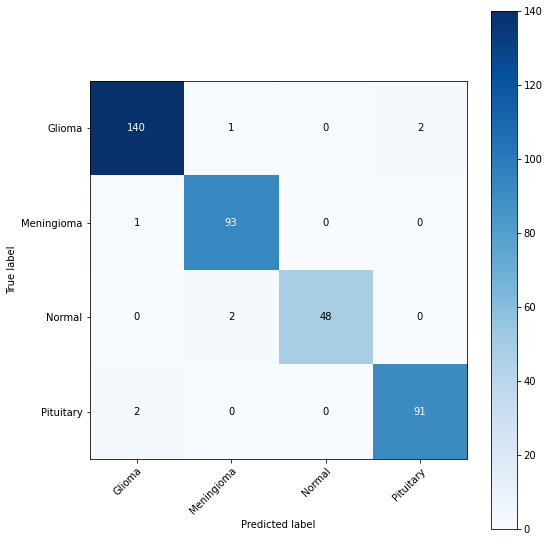

In [ ]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators_soft5=[('rf', rf), ('svm', svc_gs),('classifier', classifier),('knn',knn_3),('regression',lr)]
#create our voting classifier, inputting our models
ensemble_soft5 = VotingClassifier(estimators_soft5, voting='soft')

ensemble_soft5.fit(train_features, train_label_ids)
filename = '/content/drive/MyDrive/Thesis/Brain_Cancer_Final/en_soft5_model.sav'
pickle.dump(ensemble_soft5, open(filename, 'wb'))
 
loaded_model = pickle.load(open(filename, 'rb'))
y_test = loaded_model.predict(test_features) 

Plot_Confusion_Matrix(test_label_ids, y_test, classes = class_names)

print('\nAccuracy: {:.6f}\n'.format(accuracy_score(test_label_ids, y_test)))

print('Micro Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='micro')))
print('Micro Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='micro')))
print('Micro F1-score: {:.6f}\n'.format(f1_score(test_label_ids, y_test, average='micro')))

print('Macro Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='macro')))
print('Macro Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='macro')))
print('Macro F1-score: {:.6f}\n'.format(f1_score(test_label_ids, y_test, average='macro')))

print('Weighted Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='weighted')))
print('Weighted Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='weighted')))
print('Weighted F1-score: {:.6f}'.format(f1_score(test_label_ids, y_test, average='weighted')))

print('\nClassification Report:\n')
print(classification_report(test_label_ids, y_test, target_names=['Glioma', 'Meningioma', 'Normal', 'Pituitary']))


Confusion matrix, without normalization

Accuracy: 0.981579

Micro Precision: 0.981579
Micro Recall: 0.981579
Micro F1-score: 0.981579

Macro Precision: 0.984116
Macro Recall: 0.981719
Macro F1-score: 0.982885

Weighted Precision: 0.981634
Weighted Recall: 0.981579
Weighted F1-score: 0.981587

Classification Report:

              precision    recall  f1-score   support

      Glioma       0.98      0.98      0.98       143
  Meningioma       0.98      0.99      0.98        94
      Normal       1.00      0.98      0.99        50
   Pituitary       0.98      0.98      0.98        93

    accuracy                           0.98       380
   macro avg       0.98      0.98      0.98       380
weighted avg       0.98      0.98      0.98       380



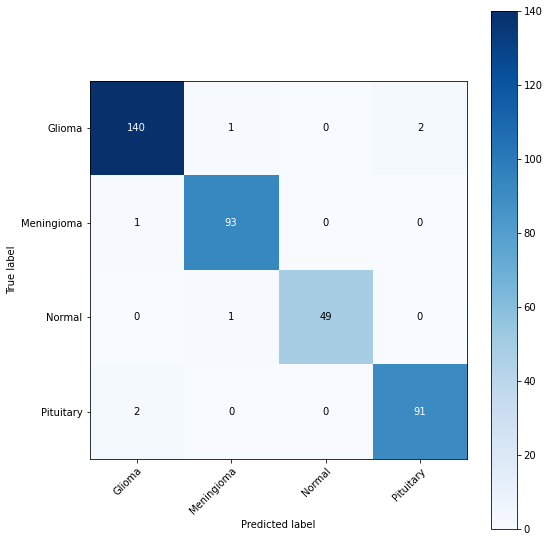

In [ ]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators_soft_5=[('rf', rf), ('svm', svc_gs),('classifier', classifier),('knn',knn_3),('regression',lr)]
#create our voting classifier, inputting our models
ensemble_soft_5 = VotingClassifier(estimators_soft_5, voting='soft')

ensemble_soft_5.fit(train_features, train_label_ids)
filename = '/content/drive/MyDrive/Thesis/Brain_Cancer_Final/en_soft_5_model.sav'
pickle.dump(ensemble_soft_5, open(filename, 'wb'))
 
loaded_model = pickle.load(open(filename, 'rb'))
y_test = loaded_model.predict(test_features) 

Plot_Confusion_Matrix(test_label_ids, y_test, classes = class_names)

print('\nAccuracy: {:.6f}\n'.format(accuracy_score(test_label_ids, y_test)))

print('Micro Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='micro')))
print('Micro Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='micro')))
print('Micro F1-score: {:.6f}\n'.format(f1_score(test_label_ids, y_test, average='micro')))

print('Macro Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='macro')))
print('Macro Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='macro')))
print('Macro F1-score: {:.6f}\n'.format(f1_score(test_label_ids, y_test, average='macro')))

print('Weighted Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='weighted')))
print('Weighted Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='weighted')))
print('Weighted F1-score: {:.6f}'.format(f1_score(test_label_ids, y_test, average='weighted')))

print('\nClassification Report:\n')
print(classification_report(test_label_ids, y_test, target_names=['Glioma', 'Meningioma', 'Normal', 'Pituitary']))

Confusion matrix, without normalization

Accuracy: 0.981579

Micro Precision: 0.981579
Micro Recall: 0.981579
Micro F1-score: 0.981579

Macro Precision: 0.984116
Macro Recall: 0.981719
Macro F1-score: 0.982885

Weighted Precision: 0.981634
Weighted Recall: 0.981579
Weighted F1-score: 0.981587


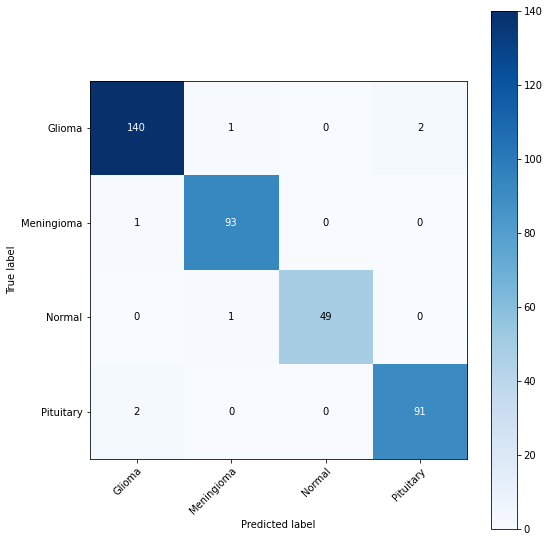

In [ ]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators_hard_5=[('rf', rf), ('svm', svc_gs),('classifier', classifier),('knn',knn_3),('regression',lr)]
#create our voting classifier, inputting our models
ensemble_hard_5 = VotingClassifier(estimators_hard_5, voting='hard')

ensemble_hard_5.fit(train_features, train_label_ids)
filename = '/content/drive/MyDrive/Thesis/Brain_Cancer_Final/en_hard_5_model.sav'
pickle.dump(ensemble_hard_5, open(filename, 'wb'))
 
loaded_model = pickle.load(open(filename, 'rb'))
y_test = loaded_model.predict(test_features) 

Plot_Confusion_Matrix(test_label_ids, y_test, classes = class_names)


print('\nAccuracy: {:.6f}\n'.format(accuracy_score(test_label_ids, y_test)))

print('Micro Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='micro')))
print('Micro Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='micro')))
print('Micro F1-score: {:.6f}\n'.format(f1_score(test_label_ids, y_test, average='micro')))

print('Macro Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='macro')))
print('Macro Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='macro')))
print('Macro F1-score: {:.6f}\n'.format(f1_score(test_label_ids, y_test, average='macro')))

print('Weighted Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='weighted')))
print('Weighted Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='weighted')))
print('Weighted F1-score: {:.6f}'.format(f1_score(test_label_ids, y_test, average='weighted')))

Confusion matrix, without normalization

Accuracy: 0.984211

Micro Precision: 0.984211
Micro Recall: 0.984211
Micro F1-score: 0.984211

Macro Precision: 0.985897
Macro Recall: 0.984407
Macro F1-score: 0.985110

Weighted Precision: 0.984285
Weighted Recall: 0.984211
Weighted F1-score: 0.984216

Classification Report:

              precision    recall  f1-score   support

      Glioma       0.99      0.98      0.98       143
  Meningioma       0.98      0.99      0.98        94
      Normal       1.00      0.98      0.99        50
   Pituitary       0.98      0.99      0.98        93

    accuracy                           0.98       380
   macro avg       0.99      0.98      0.99       380
weighted avg       0.98      0.98      0.98       380



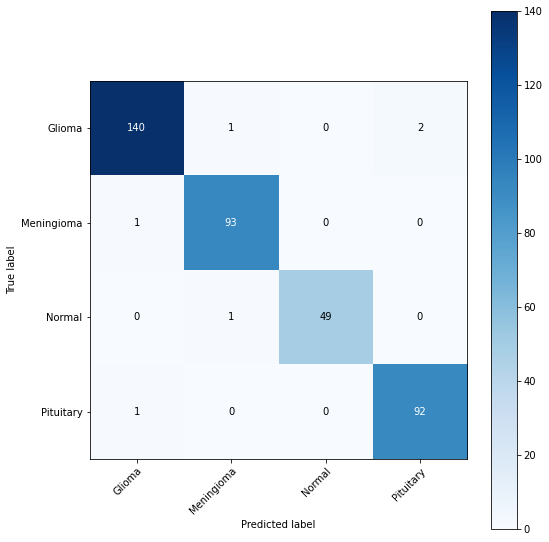

In [ ]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators_we5=[('rf', rf), ('svm', svc_gs),('classifier', classifier),('knn',knn_3),('regression',lr)]
#create our voting classifier, inputting our models
weights_we5 = [.7,.9,.9,.7,.7]

ensemble_we5 = VotingClassifier(estimators=estimators_we5, weights=weights_we5)

ensemble_we5.fit(train_features, train_label_ids)
filename = '/content/drive/MyDrive/Thesis/Brain_Cancer_Final/en_weighted5_model.sav'
pickle.dump(ensemble_we5, open(filename, 'wb'))
 
loaded_model = pickle.load(open(filename, 'rb'))
y_test = loaded_model.predict(test_features)

Plot_Confusion_Matrix(test_label_ids, y_test, classes = class_names)

print('\nAccuracy: {:.6f}\n'.format(accuracy_score(test_label_ids, y_test)))

print('Micro Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='micro')))
print('Micro Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='micro')))
print('Micro F1-score: {:.6f}\n'.format(f1_score(test_label_ids, y_test, average='micro')))

print('Macro Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='macro')))
print('Macro Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='macro')))
print('Macro F1-score: {:.6f}\n'.format(f1_score(test_label_ids, y_test, average='macro')))

print('Weighted Precision: {:.6f}'.format(precision_score(test_label_ids, y_test, average='weighted')))
print('Weighted Recall: {:.6f}'.format(recall_score(test_label_ids, y_test, average='weighted')))
print('Weighted F1-score: {:.6f}'.format(f1_score(test_label_ids, y_test, average='weighted')))

print('\nClassification Report:\n')
print(classification_report(test_label_ids, y_test, target_names=['Glioma', 'Meningioma', 'Normal', 'Pituitary']))